In [1]:
from natsort import natsorted
import os
from tqdm import tqdm
import soundfile as sf
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from utils import *
import pandas as pd

ModuleNotFoundError: No module named 'natsort'

In [ ]:
# RMVPE: window size = 2048, hop size = 320.
# MIR 1k: window length = 640, hop size = 320. sr = 16000.
# MDB stem synth: hop size = 128. sr = 44100.


# Preprocess MDB stem synth

In [ ]:
# TODO: I will think more about using MDB. 

In [ ]:
# MDB stem synth.
data_dir = '/data/pitch_estimation/dataset/MDB-stem-synth'

# Each subfolder below (e.g. pitch, wav, wav_16k) contains different features.
# one folder == one feature.
pitch = '/data/pitch_estimation/dataset/MDB-stem-synth/annotation_stems'
wav = '/data/pitch_estimation/dataset/MDB-stem-synth/audio_stems'

wav_16k = '/data/pitch_estimation/dataset/MDB-stem-synth/wav_16k'
mkdir(wav_16k)

# Resample the frequency of each waveform to 16khz. 
# get_files function returns a list of files in sorted order in a directory.
for i in tqdm(get_files(wav)):
    data, sr = sf.read(i)
    data = librosa.resample(data, orig_sr=sr, target_sr=16000)
    
    # here get_fid function returns the file name without extension.
    # We use file id to keep track of the files across folders (i.e. features).
    sf.write(os.path.join(wav_16k, f"{get_fid(i)}.wav"), data, 16000)

# Some jargon: sr = sampling rate = sampling frequency. 
# Sanity check 
for i in tqdm(get_files(wav_16k)):
    data, sr = sf.read(i)
    assert sr == 16000

In [25]:
# The hop size for pitch in time domain is 128 / 44100 = 0.0029s = 2.9ms.
# The hop size for waveform in time domain should be the same: 128 / 44100 * 16000 = 46.43 samples. 
# However, with super-long waveform, this slightly offset will result in a large error.
# We can cut the waveform into short segments to avoid this issue.
# But other datasets (e.g. MIR 1k) d't have timestamps... 
hop_size = 46
actual_hop_size = 128 / 44100 * 16000

data_length = 16000 * 30
print(data_length / hop_size)
print(data_length / actual_hop_size)

10434.782608695652
10335.9375


(59067,)
(8573,)
8572.08163265306


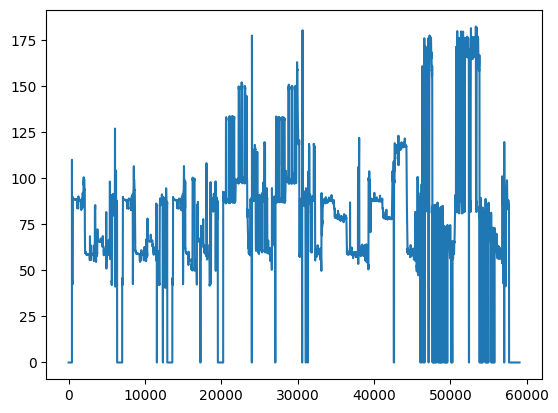

In [77]:
# Here's one resampling of pitch. 
# Here's an example. 
label = pd.read_csv('/data/pitch_estimation/dataset/MDB-stem-synth/annotation_stems/AClassicEducation_NightOwl_STEM_01.RESYN.csv',
                    header=None, names=['time', 'pitch'])
label = label.values[:, 1]
prev_shape = label.shape[0]
print(label.shape)
plt.plot(label)

# Resample pitch to 50hz. => Hop size of 320 under 16khz. 
label = librosa.resample(label, orig_sr=44100/128, target_sr=50)
print(label.shape)

# Verify the shape after resampling. 
print(prev_shape / (44100 / 128) * 50)

# This may result in artifacts...

In [72]:
# @Kyle forgot to delete .DS_store haha. 
pitch_files = list(filter(lambda i: ".csv" in i, get_files('/data/pitch_estimation/dataset/MDB-stem-synth/annotation_stems')))
min_pitch, max_pitch = 1000, 0
for i in tqdm(pitch_files):
    label = pd.read_csv(i, header=None, names=['time', 'pitch'])
    label = label.values[:, 1]
    min_pitch = min(min_pitch, label.min())
    max_pitch = max(max_pitch, label.max())

print(min_pitch, max_pitch)

100%|██████████| 230/230 [00:03<00:00, 63.32it/s] 

0.0 1254.845215


In [64]:
# Create spectrogram for waveform.
# We can use the same hop size as pitch.
# window size = 640. 
# This window size is also something that we can experiment with. 

data, sr = sf.read('/data/pitch_estimation/dataset/MDB-stem-synth/wav_16k/AClassicEducation_NightOwl_STEM_01.wav')
mel_spec = librosa.feature.melspectrogram(data, sr=sr, n_fft=640, hop_length=320, n_mels=128)

In [67]:
sr

16000

In [66]:
data.shape

(2743043,)

# Preprocess MIR 1k

In [56]:
# Let's first preprocess it's pitch into npy files. 
# Here's one example. 
# .strip() is used to remove the trailing newline character.
pitch = read('/data/pitch_estimation/dataset/MIR-1K/PitchLabel/abjones_1_01.pv').strip()

# Split into \n and eval each element. 
pitch = list(map(float, pitch.split('\n')))
pitch = np.array(pitch)
pitch.shape

(579,)

In [60]:
# Convert all pitch files to npy.
input_dir = '/data/pitch_estimation/dataset/MIR-1K/PitchLabel'
save_dir = '/data/pitch_estimation/dataset/MIR-1K/pitch_50'
mkdir(save_dir)

files = list(filter(lambda i: ".pv" in i, get_files(input_dir)))
for file in tqdm(files):
    pitch = read(file).strip()
    pitch = list(map(float, pitch.split('\n')))
    pitch = np.array(pitch)
    np.save(os.path.join(save_dir, f"{get_fid(file)}.npy"), pitch)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3705.69it/s]


In [82]:
min_pitch, max_pitch = 1000, 0
for i in tqdm(get_files(save_dir)):
    pitch = np.load(i)
    min_pitch = min(min_pitch, pitch[~np.isclose(pitch, 0.0)].min())
    max_pitch = max(max_pitch, pitch.max())
min_pitch, max_pitch

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7213.69it/s]


(np.float64(36.4027), np.float64(76.1935))

In [61]:
# Concern: the window size is 640, but the window size for the MDB maybe the same as hop size. 
# So we will train one model on MDB and one model on MIR-1k.
# And then try to train one model on both dataset. 

In [79]:
# Create train val test split for MIR 1k. 
fids = [get_fid(i) for i in get_files('/data/pitch_estimation/dataset/MIR-1K/Wavfile')]
len(fids)

1000

In [80]:
# let's do a 80-5-10 split.
random.seed(888)
random.shuffle(fids)

train_fids = fids[:850]
val_fids = fids[850:900]
test_fids = fids[900:]

write('/data/pitch_estimation/dataset/MIR-1K/train.txt', '\n'.join(train_fids))
write('/data/pitch_estimation/dataset/MIR-1K/val.txt', '\n'.join(val_fids))
write('/data/pitch_estimation/dataset/MIR-1K/test.txt', '\n'.join(test_fids))

In [128]:
# We merge both channels. 
# We set n_mels = 256 to have better resolution since the pitch label is mostly concentrated from 30 to 80. 
save_dir = '/data/pitch_estimation/dataset/MIR-1K/mel_spec_both'
mkdir(save_dir)
for i in tqdm(get_files('/data/pitch_estimation/dataset/MIR-1K/Wavfile')):
    data, sr = sf.read(i)
    assert sr == 16000
    mel_spec = librosa.feature.melspectrogram(y = data.mean(axis = 1), sr=sr, n_fft=640, hop_length=320, n_mels=256, 
                                              fmin=30, fmax=8000)
    
    # The pitch label starts at the first frame. 
    mel_spec = mel_spec[:, 1:]
    
    # Next take min of mel_spec and pitch. 
    pitch_len = np.load(os.path.join('/data/pitch_estimation/dataset/MIR-1K/pitch_50', f"{get_fid(i)}.npy")).shape[0]
    mel_spec = mel_spec[:, :pitch_len]
    np.save(os.path.join(save_dir, f"{get_fid(i)}.npy"), mel_spec)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:13<00:00, 75.50it/s]


In [97]:
# Check the shape of the mel_spec and pitch.
for i, j in zip(get_files('/data/pitch_estimation/dataset/MIR-1K/pitch_50/'), get_files('/data/pitch_estimation/dataset/MIR-1K/mel_spec_both')):
    pitch = np.load(i)
    mel_spec = np.load(j)
    assert pitch.shape[0] == mel_spec.shape[1]

/home/blastaistudent/miniconda3/envs/pitch/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


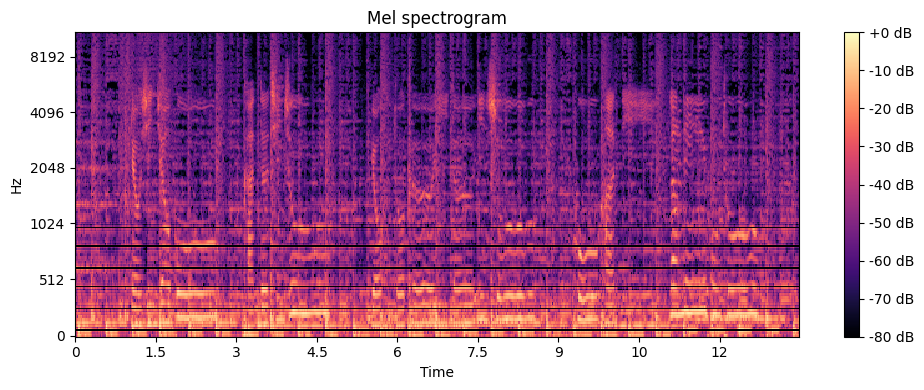

In [131]:
# One example of creating mel spec. 
data, sr = sf.read('/data/pitch_estimation/dataset/MIR-1K/Wavfile/abjones_1_01.wav')

# extract mel spectrogram
mel_spec = librosa.feature.melspectrogram(y = data.mean(axis = 1), sr=sr, n_fft=640, hop_length=320, n_mels=256, fmax=8000, fmin = 30)

# plot mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [122]:
1200 * np.log2(31.7 / 10)

np.float64(1997.379408437619)

In [23]:
# TODO: copy this block for MIR 1k dataset and dataloader. 
# Create a pytorch dataset for MIR 1k.


CENTS_PER_BIN = 20  # cents
MAX_FMAX = 2006.  # hz
PITCH_BINS = 360
SAMPLE_RATE = 16000  # hz
WINDOW_SIZE = 1024

def frequency_to_cents(frequency):
    """Convert frequency in Hz to cents"""
    return 1200 * torch.log2(frequency / 10.)

# We can use this function to quantize the pitch to the nearest bin.
# but 1997 actually corresponds to 31.7hz instead of 32.7 as noted in the paper. 
def cents_to_bins(cents, quantize_fn=torch.floor):
    """Converts cents to pitch bins"""
    bins = (cents - 1997.3794084376191) / CENTS_PER_BIN
    return quantize_fn(bins).int()

def frequency_to_bins(frequency, quantize_fn=torch.floor):
    """Convert frequency in Hz to pitch bins"""
    mask = torch.isclose(frequency, torch.tensor([0.0], dtype = torch.float32))
    result = cents_to_bins(frequency_to_cents(frequency), quantize_fn)
    
    # Pitch label: 0 - 359 
    # 360: unvoiced.
    # Total of 361 bins.
    result[mask] = 360
    return result 


class MIR1kDataset(Dataset):
    def __init__(self, mel_dir, pitch_dir, fids):
        self.mel_dir = mel_dir
        self.pitch_dir = pitch_dir
        
        # File ids.
        fids = read(fids).strip().split('\n')
        
        # Check if all features files exist. 
        self.fids = fids
        for i in fids:
            assert os.path.exists(os.path.join(mel_dir, f"{i}.npy"))
            assert os.path.exists(os.path.join(pitch_dir, f"{i}.npy"))
    def __len__(self):
        return len(self.fids)

    def __getitem__(self, idx):
        fid = self.fids[idx]
        mel = np.load(os.path.join(self.mel_dir, f"{fid}.npy"))
        pitch = np.load(os.path.join(self.pitch_dir, f"{fid}.npy"))
        return mel, pitch

# Create a collate fn that randomly crop the waveform and pitch.
# min_len: 1 sec of mel. max_len: 3sec of mel.
def collate_fn(batch, min_len = 50, max_len = 150):
    mel = [i[0] for i in batch]
    pitch = [i[1] for i in batch]
    
    # Randomly crop the mel and pitch.
    crop_len = random.randint(min_len, max_len)
    min_mel_len = min([i.shape[1] for i in mel])
    
    random_start = random.randint(0, min_mel_len - crop_len)
    
    # (B, C, crop_len)
    mel = torch.stack([torch.tensor(i[:, random_start:random_start + crop_len]) for i in mel]).float()
    
    # (B, crop_len)
    pitch = torch.stack([torch.tensor(i[random_start:random_start + crop_len]) for i in pitch]).float()
    orig_pitch = pitch.clone()
    
    # Convert pitch to cents.
    pitch = frequency_to_bins(pitch)
    return mel, pitch, orig_pitch

# Train dataset and dataloader.
train_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both', 
                             pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50', 
                             fids='/data/pitch_estimation/dataset/MIR-1K/train.txt')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)



# Val dataset and dataloader.
val_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                           pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                           fids='/data/pitch_estimation/dataset/MIR-1K/val.txt')
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


# Test dataset and dataloader.
test_dataset = MIR1kDataset(mel_dir='/data/pitch_estimation/dataset/MIR-1K/mel_spec_both',
                            pitch_dir='/data/pitch_estimation/dataset/MIR-1K/pitch_50',
                            fids='/data/pitch_estimation/dataset/MIR-1K/test.txt')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [18]:
frequency_to_bins(torch.tensor(2006))

tensor(359, dtype=torch.int32)

In [24]:
for index, (mel, pitch, orig_pitch) in enumerate(train_dataloader):
    assert (pitch >= 0).all()

In [130]:
# Get a batch of data.
mel, pitch = next(iter(train_dataloader))
print(mel.shape, pitch.shape)

torch.Size([16, 256, 119]) torch.Size([16, 119])
